<h1><center>

![](https://i.imgur.com/jrRGMfx.png)

AI PRACTITIONER COURSE 

ASSIGNMENT - SESSION 16 - Interactive decision making: Contextual & Multi-armed Bandits

**&copy; 2020 VTCA-COTAI. Internal Use Only.**

</center></h1>


# 15.1 Theory Review

## 15.1.1 [1 Point] MABs objective function
- What do multi-armed bandit algorithms try to maximize? Why is it a special case of MDP learning?
- Bài toán MAB tối ưu cái gì? Vì sao nó là trường hợp đặc biệt của bài toán học-ra-quyết-định trong MDP?

## 15.1.2 [1 Point] MAB algorithms
- What are the similarity and differences between MAB algorithms? Describe specifically for the learned algorithms: $\epsilon$-greedy, Thompson sampling, UCB. 
- Liệt kê các điểm giống & khác giữa các giải thuật MAB, cụ thể cho 3 giải thuật đã được học.


**15.1.1**

Bài toán MAB : Tối ưu value action để chọn ra hành động đem lại nhiều reward nhất  
Điểm đặc biệt : Học cách ra quyết định ngay trong quá trình tương tác bằng tìm kiếm sự cân bằng giữa Exploitation và Exploration

**15.1.2**

*Giống nhau* : 

Đều là những thuật toán đi tìm kiếm sự cân bằng giữa exploitation và exploration để đem lại reward nhiều nhất cũng giảm khả năng bỏ sót cá lựa chọn tối ưu

*Khác nhau* :

$\epsilon$-greedy : Random 1 giá trị trong khoảng (0,1) nếu giá trị này <= $\epsilon$ thì thực hiện **khai phá** ngược lại thực hiện **khai thác**

UCB : quan tâm nhiều hơn về tính không chăc chắn(dộ lệch lớn) của mỗi biến thể. Càng không chắc chắn về một quảng cáo, thì càng phải ưu tiên tập trung **khai phá**

Thompson sampling : Phương pháp Lấy mẫu Thompson chỉ thực hiện được khi các action của ta trả ra reward tuân theo phân phối Bernoulli. Phần khai phá dựa trên phân phối Beta, có thể khai quát hóa để lấy mẫu từ bất kỳ phân phối nào trên các tham số



# 15.2 [6 Points] Coding Practice


Để đơn giản hóa code, bài Assignment này sẽ dùng thư viện ``matplotlib`` để vẽ đồ thị, học viên được khuyến khích sửa các đoạn code vẽ đồ thị lại thành dùng thư viện ``plotly`` như trên bài lab

## Import thư viện

In [ ]:
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import math

## Các class hỗ trợ

Ta viết 3 class tượng trưng cho 3 loại máy đánh bạc:
- ``NormalMachine`` máy đánh bạc trả ra reward tuân theo phân phối chuẩn (chi phối bởi 2 biến ``mean`` và ``std``)
- ``BernoulliMachine`` máy đánh bạc trả ra reward tuân theo phân phối Bernoulli (chi phối bởi biến ``prob``)
- ``UniformMachine`` máy đánh bạc trả ra rewward tuân theo phân phối đều rời rạc (chi phối bởi 2 biến ``low`` và ``high``)

Trong mỗi class đều có hàm ``pull``, gọi hàm này sẽ trả ra reward của máy đó

In [ ]:
class NormalMachine:
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std
  def pull(self):
    return np.random.normal(self.mean, self.std)

class BernoulliMachine:
  def __init__(self, prob):
    self.prob = prob
  def pull(self):
    # reward trả ra hoặc là 15, hoặc là 0
    return 15 * bernoulli.rvs(self.prob)

class UniformMachine:
  def __init__(self, low, high):
    self.low = low
    self.high = high
  def pull(self):
    # reward trả ra trong khoảng [low, high-1]
    return np.random.randint(self.low, self.high)


Ta khởi tạo 4 máy đánh bạc:
- Máy 1: phân phối chuẩn, ``mean = 9, std = 2``
- Máy 2: phân phối chuẩn, ``mean = 8, std = 3``
- Máy 3: phân phối đều rời rạc, ``low = 8, high = 11``
- Máy 4: phân phối bernoulli, ``prob = 0.5``
Sau đó, gom 4 máy thành 1 list ``machine_list``

In [ ]:
machine_1 = NormalMachine(9, 3)
machine_2 = NormalMachine(8, 4)
machine_3 = UniformMachine(8, 11)
machine_4 = BernoulliMachine(0.5)

machine_list = [machine_1, machine_2, machine_3, machine_4]

In [ ]:
class Report:
  def __init__(self):
    self.play_history = []
    self.total_play = [0,0,0,0]
    self.Q = {
        0: [0],
        1: [0],
        2: [0],
        3: [0]
    }
    self.reward_history = {
        0: [0],
        1: [0],
        2: [0],
        3: [0]
    }
    self.total_reward = 0

  def record(self, machine_index, reward):
    self.play_history.append(machine_index)
    self.total_play[machine_index] += 1
    # reward_history sẽ bằng reward hiện tại, cộng dồn với reward của timestep trước đó
    self.reward_history[machine_index].append(self.reward_history[machine_index][-1]+reward)
    self.Q[machine_index].append(self.reward_history[machine_index][-1] / self.total_play[machine_index])
    self.total_reward += reward

  def plot_average_reward(self):
    plt.figure(figsize=(15,10))
    for key, value in self.Q.items():
      plt.plot(range(self.total_play[key]), value[1:], label='Machine {}'.format(key+1))
    plt.legend()
    plt.title('Average rewards after 1000 time steps')
    plt.show()

  def get_latest_Q(self, machine_index=-1):
    if machine_index >= 0:
      return self.Q[machine_index][-1]
    else:
      return [self.Q[0][-1], self.Q[1][-1], self.Q[2][-1], self.Q[3][-1]]

  def is_played_at_least_one(self, machine_index):
    if self.total_play[machine_index] == 0:
      return False
    return True

  def print_report(self):
    count_used = np.unique(self.play_history, return_counts=True)
    max_used = max(count_used[1])
    index_max_used = list(count_used[1]).index(max_used)
    print('After playing {} times, the most used machine is Machine {} with {} used\nTotal rewards earned = {}$'.format(
      len(self.play_history),
      index_max_used,
      max_used,
      self.total_reward
    ))
    print('Number of used time for each machine')
    for i in range(len(count_used[0])):
      print('Machine {}: {}'.format(count_used[0][i], count_used[1][i]))
      
  


## Chơi thử mỗi máy 1000 lần

Ta thực hiện chơi mỗi máy 1000 lần để thấy được máy nào sẽ cho ra reward trung bình tốt nhất.
### TODOs [1 Point]
- Thực hiện chơi mỗi máy 1000 lần, sau mỗi lần chơi cần lưu lại lịch sử vào biến ``rich_kid_report``
- Sau đó gọi hàm ``plot_average_reward`` để vẽ đồ thị

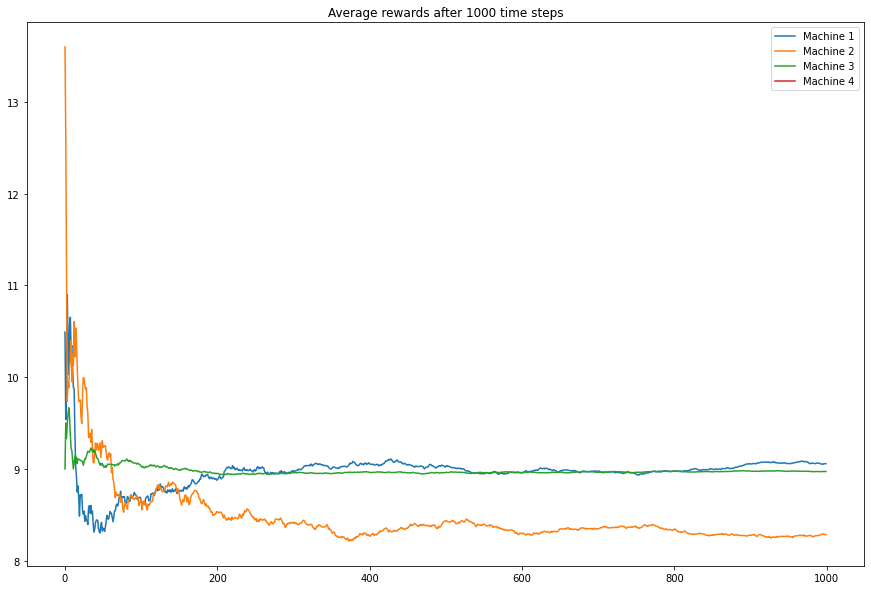

In [ ]:
np.random.seed(42)

rich_kid_report = Report()

# YOUR CODE GOES HERE
for i in range(3) :
    for j in range(1000):
        machine_index = machine_list[i]
        rich_kid_report.record(i,machine_index.pull())
rich_kid_report.plot_average_reward()

Giả sử mỗi lần chơi ta phải tốn **6\$**, thì để chơi hết 4000 lần như trên, phải tốn tổng cộng **24000\$**. Rất tiếc không phải ai sinh ra cũng ở sẵn vạch đích nên chúng ta sẽ thử các biện pháp khác **"thông minh hơn"** để xem có thể tìm ra máy tốt nhất với chi phí thấp nhất không nhé

## Random Selection

### TODOs [1 Point]
- Ở phần này, ta thực hiện phương pháp Random Selection theo mã giả như sau:
  - Viết hàm ``random_selection`` hàm này trả về ngẫu nhiên index của 1 trong 4 máy.
- Chơi 1000 lần bằng phương pháp Random Selection
- Gọi hàm ``print_report`` để in ra thống kê

In [ ]:
np.random.seed(42)

random_report = Report()

# YOUR CODE GOES HERE
def random_selection() :
    return np.random.randint(4)

for i in range(1000) :
    random_index = random_selection()
    random_report.record(random_index,machine_list[random_index].pull())
random_report.print_report()

After playing 1000 times, the most used machine is Machine 0 with 259 used
Total rewards earned = 8635.647460939592$
Number of used time for each machine
Machine 0: 259
Machine 1: 257
Machine 2: 242
Machine 3: 242


## Epsilon Greedy

### TODOs [2 Point]
- $ $ Ở phần này, chúng ta sẽ thực hiện phương pháp **Epsilon Greedy** theo mã giả như sau:
  - Viết hàm ``epsilon_greedy``, hàm này nhận vào ``ep`` là giá trị của epsilon (xác suất thực hiện **khám phá**) và trả ra ``machine_index`` là số thứ tự của máy phải chơi và ``epsilon_greedy_report``. Các bước thực hiện
    - Dùng hàm ``bernoulli.rvs`` để lấy mẫu từ phân phối Bernoulli với xác suất chính là biến ``ep``
    - Dựa vào kết quả trên để quyết định **khai thác** hoặc **khám phá**
    - Nếu là **khai thác**, trả ra index của máy có giá trị $Q_t(a)$ hiện tại lớn nhất.
    - Nếu là **khám phá**, random ra index của 1 trong các máy còn lại.
    - Return ra index
- Chơi 1000 lần bằng phương pháp Random Selection
- Gọi hàm ``print_report`` để in ra thống kê  

In [ ]:
np.random.seed(42)

epsilon_greedy_report = Report()
e = 0.15
# YOUR CODE GOES HERE
def epsilon_greedy(ep) :
    explore_mode = bernoulli.rvs(ep)
    if explore_mode :
        return np.random.randint(4)
    return np.argmax(epsilon_greedy_report.get_latest_Q())
for i in range(1000):
    index = epsilon_greedy(e)
    epsilon_greedy_report.record(index,machine_list[index].pull())
epsilon_greedy_report.print_report()

After playing 1000 times, the most used machine is Machine 2 with 551 used
Total rewards earned = 8900.15438111645$
Number of used time for each machine
Machine 0: 365
Machine 1: 36
Machine 2: 551
Machine 3: 48


## Upper Confidence Bound (UCB)
  

Tiếp theo, ta có class ``Report``  để lưu trữ dữ liệu thống kê và hỗ trợ vẽ đồ thị.

Các thông số của class ``Report`` gồm
- ``play_history``: lịch sử cho biết tại từng thời điểm, ta đã chọn chơi máy nào
- ``total_play``: tổng số lần chơi của mỗi máy
- ``Q``: dictionary, lịch sử cho biết tại từng thời điểm, $Q_t(a)$ có giá trị là bao nhiêu
- ``reward_history``: dictionary, lịch sử cho biết tại từng thời điểm, tổng reward từ đầu cho đến thời điểm đó là bao nhiêu
- ``total_reward``: tổng số reward nhận được, bất kể chơi máy nào

Class ``Report`` còn có các hàm hỗ trợ:
- ``record``: hàm để lưu lại thông tin sau mỗi lần chơi, tham số truyền vào gồm:
  - ``machine_index``: máy số mấy
  - ``reward``: reward do máy đó trả ra (gọi hàm ``pull``)
- ``get_latest_Q``: hàm để lấy ra giá trị Q mới nhất, nếu truyền vào ``machine_index`` thì lấy ra giá trị của máy đó, nếu truyền vào ``-1`` thì lấy ra giá trị của cả 4 máy.
- ``is_played_at_least_one``: hàm này nhận vào ``machine_index`` và trả ra giá trị ``False`` nếu máy đó chưa được chơi lần nào, ``True`` nếu đã được chơi
- ``plot_average_reward``: hàm để vẽ ra giá trị của $Q_t(a)$ cho tất cả thời điểm
- ``print_report``: hàm này sẽ in ra thống kê máy nào được chơi nhiều nhất và tổng reward thu được

### TODOs [2 Point]

- $ $Ở phần này ta thực hiện phương pháp UCB theo mã giả như sau
  - Viết hàm ``ucb``, hàm này nhận vào ``ucb_report`` và trả ra ``machine_index`` là số thứ tự của máy phải chơi. Các bước thực hiện
    - Với mỗi machine
      - Nếu machine đó đã được chơi ít nhất 1 lần thì 
        - Tính ``delta`` theo công thức $\delta = 2 \sqrt{\frac{\log{(t)}}{N_t(a)}}$ Với $t$ là tổng số time step hiện tại, và $N_t(a)$ là số lần chọn chơi máy đó.
        - Tính $\text{ucb} = Q_t(a) + \delta$ với $Q_t(a)$ là giá trị Q mới nhất của máy đó
    - Nếu tất cả machine đều chưa được chơi lần nào, ta trả ra index ngẫu nhiên, ngược lại trả ra index của machine có ``ucb`` lớn nhất
- Chơi 1000 lần bằng phương pháp ``UCB``
- Gọi hàm ``print_report`` để in ra thống kê 
 

 Chơi mỗi máy 1 lần rồi UCB


In [ ]:
np.random.seed(42)

ucb_report = Report()


# YOUR CODE GOES HERE
def ucb(ucb_report,cur_iter):
    ad_index = 0
    max_ucb = 0
    for index in range(4) :
            delta = 2*math.sqrt(math.log(cur_iter + 1)/ucb_report.total_play[index])
            ucb1 = ucb_report.get_latest_Q(index) + delta
            ucb1 = 1e400
        if ucb1 > max_ucb :
            max_ucb = ucb1
            ad_index = index
    return ad_index

for i in range(1000):
    ad_index = ucb(ucb_report,i)
    ucb_report.record(ad_index, machine_list[ad_index].pull())
ucb_report.print_report()
        
                                

After playing 1000 times, the most used machine is Machine 0 with 723 used
Total rewards earned = 9060.005662068677$
Number of used time for each machine
Machine 0: 723
Machine 1: 7
Machine 2: 258
Machine 3: 12


## Ôn tập lý thuyết Phân phối Beta và Lấy mẫu Thompson

Phương pháp Lấy mẫu Thompson chỉ thực hiện được khi các action của ta trả ra reward tuân theo phân phối Bernoulli
- Ví dụ: chiếu quảng cáo, nếu quảng cáo được click thì reward là 1, ngược lại reward là 0

Trước tiên ta cần hiểu ý nghĩa phân phối Beta

**Phân phối Beta**

Là tiên nghiệm của phân phối Bernoulli. Để hiểu ý nghĩa của câu nói trên hãy xem 2 đoạn code minh họa bên dưới

Đoạn code bên dưới sẽ vẽ ra **hàm mật độ xác suất** của phân phối Beta với ``alpha = 10`` và ``beta = 20``

``alpha`` và ``beta`` được hiểu như sau:
> Trong 30 lần thử lấy mẫu Bernoulli, 10 lần ra kết quả **CÓ** và 20 lần ra kết quả **KHÔNG**. Suy ra phân phối Bernoulli này có thể có xác suất để kết quả là **CÓ** = 0.3

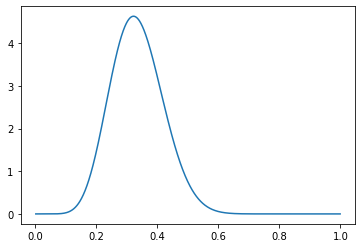

In [ ]:
from scipy.stats import beta
# alpha
a = 10
# beta
b = 20
x = np.linspace(0.001, 0.999, 1000)
plt.plot(x, beta(a, b).pdf(x))

Ta vẽ lại **Hàm mật độ xác suất** với ``alpha=100`` và ``beta=200`` (Với 300 lần lấy mẫu Bernoulli, 100 lần ra kết quả **CÓ** và 200 lần ra kết quả **KHÔNG**)

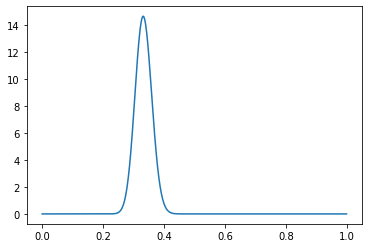

In [ ]:
# alpha
a = 100
# beta
b = 200
x = np.linspace(0.001, 0.999, 1000)
plt.plot(x, beta(a, b).pdf(x))

Ta thấy hình ở dưới hẹp hơn hình bên trên, lý do là vì ta đã thử lấy mẫu 300 lần nên ta có thể tự tin kết luận xác suất ra **CÓ** của phân phối Bernoulli này là xấp xỉ 0.3.

Còn ở hình bên trên, do mới chỉ lấy mẫu 30 lần, nên xác suất có khả năng nằm trong khoảng từ 0.2 đến 0.4

**Lấy mẫu Thompson**

Thay vì tính $Q_t(a)$ theo công thức **số lần click chia tổng số lần xuất hiện**, ta sẽ tính $Q_t(a)$ bằng cách:
- Với mỗi quảng cáo:
  - Tạo ra ``alpha`` và ``beta`` tượng trưng cho niềm tin của ta vào CTR của quảng cáo (tạm gọi là ``priors[0]`` và ``priors[1]``)
    - Ví dụ, ta có niềm tin là CTR xấp xỉ 0.6 thì ``priors[0]=60`` và ``priors[1]=40``
    - Ví dụ, ta không dám khẳng định CTR thì ``priors[0]=1`` và ``priors[1]=1``
  - Sau đó, ta tạo ra ``alpha`` và ``beta`` mới theo công thức sau:
    - ``alpha = priors[0] + số lượt click``
    - ``beta = priors[1] + số lượt hiển thị nhưng không được click``
  - Cuối cùng ta thực hiện lấy mẫu từ phân phối Beta trên.
- Chọn ra quảng cáo có giá trị $Q_t(a)$ cao nhất.

 